# VES Results

In [38]:
import glob
import json

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats


## Table of Contents

1. [Ablation on NUM_PATH](#ablation-on-num_path)
    - [Ablation Test on NUM_PATH with Learned Lengthscale](#ablation-test-on-num_path-with-learned-lengthscale)
    - [Ablation Test on NUM_PATH with Correct Lengthscale](#ablation-test-on-num_path-with-correct-lengthscale)
2. [Empirical Equivalence between EI and VES-Exp](#empirical-equivalence-between-ei-and-ves-exp)
3. [VES-Gamma Performance compared with EI and MES](#ves-gamma-performance-compared-with-ei-and-mes)
    - [Prior Samples](#prior-samples)
        - [Learned Lengthscale (MAP)](#learned-lengthscale-map)
        - [Correct Lengthscale](#correct-lengthscale)
    - [Test Functions](#test-functions)
    - [Real-world Benchmarks](#real-world-benchmarks)


## Ablation on NUM_PATH

### Abalation Test on NUM_PATH with Learned Lengthscale

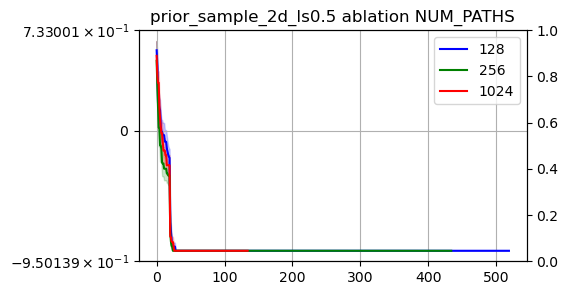

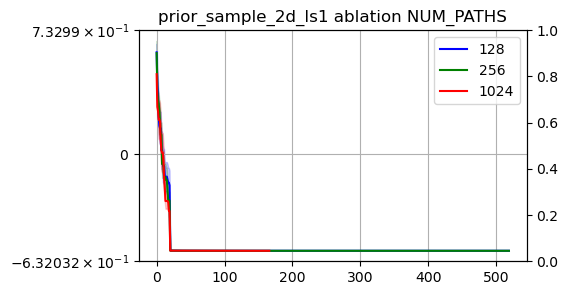

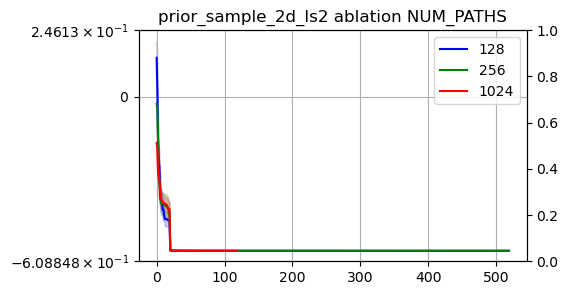

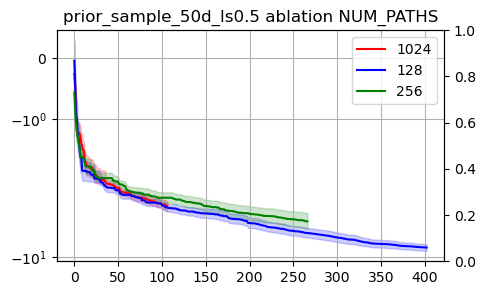

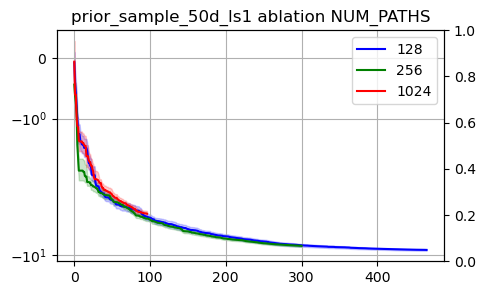

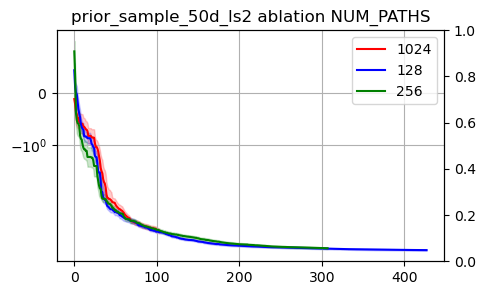

In [39]:
benchmarks = ['prior_sample_2d_ls0.5', 'prior_sample_2d_ls1', 'prior_sample_2d_ls2','prior_sample_50d_ls0.5', 'prior_sample_50d_ls1', 'prior_sample_50d_ls2']
ablation_path = 'results/ves_ablation_paths_sep_17/*'
run_dirs = glob.glob(ablation_path)

for benchmark in benchmarks:
    
    def general_dir_match(
            args: dict,
    ):
        if not 'prior_sample' in benchmark:
            return True
        else:
            ls = float(benchmark.split('_')[-1][2:])
            set_ls = args['set_lengthscale'] 
            return set_ls is None# and float(ls) == float(set_ls)
    
    relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]

    ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
    mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
    # remove ei_dirs from relevant_dirs
    relevant_dirs = [d for d in relevant_dirs if d not in ei_dirs]
    relevant_dirs = [d for d in relevant_dirs if general_dir_match(json.load(open(f'{d}/args.json')))]
    
    #default_dirs = [d for d in relevant_dirs if def_dir_match(json.load(open(f'{d}/args.json'))) and 'train_y_ves.npy' in d]
    
    # ablation NUM_PATHS
    fig, ax = plt.subplots(figsize=(5, 3))
    ax2 = ax.twinx()
    num_paths = [128, 256, 1024]
    colors = {
        128: 'blue',
        256: 'green',
        1024: 'red'
    }
    ablation_dirs = [d for d in relevant_dirs if
                     json.load(open(f'{d}/args.json'))['num_paths'] in num_paths] #+ default_dirs
    ablation_hashes = list(set([int(d.split('/')[-1].split('_')[1]) for d in ablation_dirs]))
    
    for h in ablation_hashes:
        dirs = [d for d in ablation_dirs if int(d.split('/')[-1].split('_')[1]) == h]
        ves_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ves.npy')) for d in dirs]
        
        if len(ves_y) == 0:
            continue
        min_len = min([len(y) for y in ves_y])
        ves_y = [y[:min_len] for y in ves_y]
        ves_y = -np.stack(ves_y).squeeze(-1)
        ves_y_mean = ves_y.mean(axis=0)
        ves_y_std = ves_y.std(axis=0)/ np.sqrt(len(ves_y))
        
        ax.plot(ves_y_mean, label=f'{json.load(open(f"{dirs[0]}/args.json"))["num_paths"]}', color=colors[json.load(open(f"{dirs[0]}/args.json"))["num_paths"]])
        ax.fill_between(np.arange(len(ves_y_mean)), ves_y_mean-ves_y_std, ves_y_mean+ves_y_std, alpha=0.2, color=colors[json.load(open(f"{dirs[0]}/args.json"))["num_paths"]])
        ax.grid()
    
    ax.legend()
    ax.set_title(f'{benchmark} ablation NUM_PATHS')
    if benchmark == 'branin2':
        ax.set_yscale('log')
    if benchmark.startswith('prior_sample'):
        # find best value
        ax.set_yscale('symlog')
    plt.show()
    
    

### Ablation Test on NUM_PATH with Correct Lengthscale

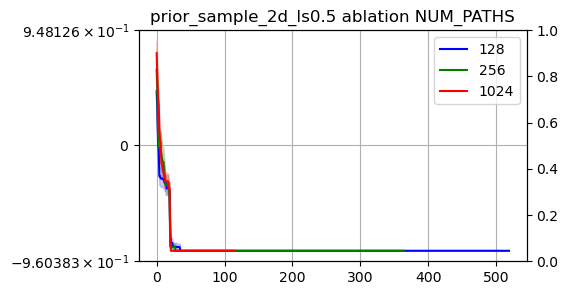

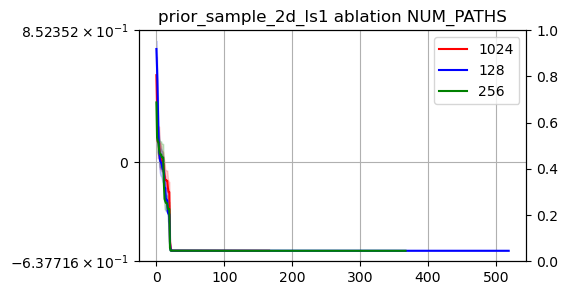

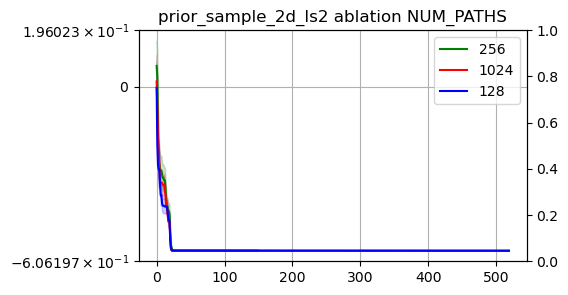

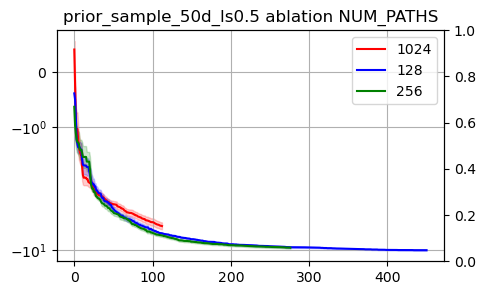

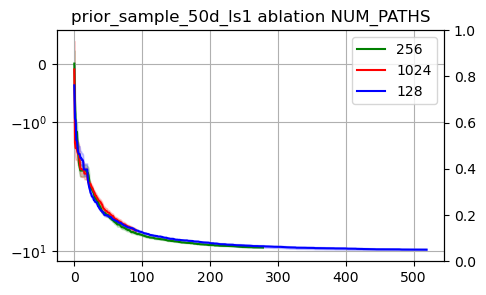

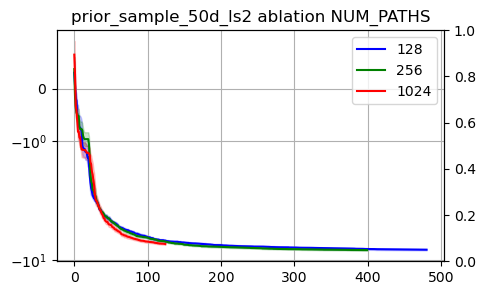

In [40]:
for benchmark in benchmarks:

    def general_dir_match(
            args: dict,
    ):
        if not 'prior_sample' in benchmark:
            return True
        else:
            ls = float(benchmark.split('_')[-1][2:])
            set_ls = args['set_lengthscale']
            return set_ls is not None and set_ls == ls

    relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]


    def def_dir_match(
            args: dict
    ):
        return args['clamp_min'] == 1e-10 \
            and args['sample_around_best'] == True \
            and args['acqf_raw_samples'] == 512 \
            and args['num_paths'] == 64 \
            and args['num_iter'] == 50


    ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
    mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
    # remove ei_dirs from relevant_dirs
    relevant_dirs = [d for d in relevant_dirs if d not in ei_dirs]
    relevant_dirs = [d for d in relevant_dirs if general_dir_match(json.load(open(f'{d}/args.json')))]

    default_dirs = [d for d in relevant_dirs if def_dir_match(json.load(open(f'{d}/args.json'))) and 'train_y_ves.npy' in d]

    # ablation NUM_PATHS
    fig, ax = plt.subplots(figsize=(5, 3))
    ax2= ax.twinx()
    num_paths = [128, 256, 1024]
    colors = {
        128: 'blue',
        256: 'green',
        1024: 'red'
    }
    ablation_dirs = [d for d in relevant_dirs if
                     json.load(open(f'{d}/args.json'))['num_paths'] in num_paths] + default_dirs
    ablation_hashes = list(set([int(d.split('/')[-1].split('_')[1]) for d in ablation_dirs]))

    for h in ablation_hashes:
        dirs = [d for d in ablation_dirs if int(d.split('/')[-1].split('_')[1]) == h]
        ves_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ves.npy')) for d in dirs]
        if len(ves_y) == 0:
            continue
        min_len = min([len(y) for y in ves_y])
        ves_y = [y[:min_len] for y in ves_y]
        ves_y = -np.stack(ves_y).squeeze(-1)
        ves_y_mean = ves_y.mean(axis=0)
        ves_y_std = ves_y.std(axis=0)/ np.sqrt(len(ves_y))
        ax.plot(ves_y_mean, label=f'{json.load(open(f"{dirs[0]}/args.json"))["num_paths"]}', color=colors[json.load(open(f"{dirs[0]}/args.json"))["num_paths"]])
        ax.fill_between(np.arange(len(ves_y_mean)), ves_y_mean-ves_y_std, ves_y_mean+ves_y_std, alpha=0.2, color=colors[json.load(open(f"{dirs[0]}/args.json"))["num_paths"]])
        ax.grid()
    
    ax.legend()
    ax.set_title(f'{benchmark} ablation NUM_PATHS')
    if benchmark == 'branin2':
        ax.set_yscale('log')
    if benchmark.startswith('prior_sample'):
        # find best value
        ax.set_yscale('symlog')
    plt.show()

## Empirical Equivalence between EI and VES-Exp

branin2: 0.9673076923076923
hartmann6: 0.9923076923076923
rover: 0.7807692307692308
mopta08: 0.8615384615384616
prior_sample_2d_ls0.5: 0.9865384615384616
prior_sample_2d_ls1: 0.9653846153846154
prior_sample_2d_ls2: 0.23846153846153847
prior_sample_50d_ls0.5: 0.3038461538461538


/opt/anaconda3/envs/botorchEnv2/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


prior_sample_50d_ls1: 0.926923076923077
prior_sample_50d_ls2: 0.9923076923076923


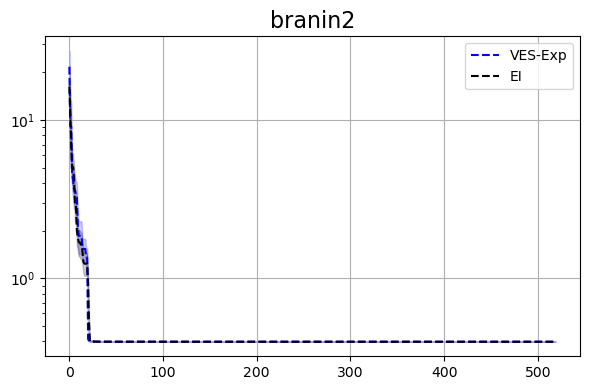

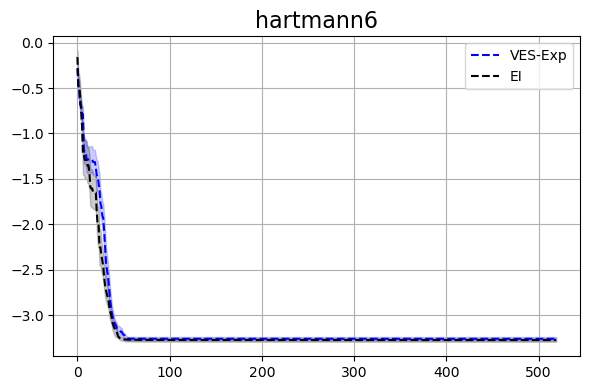

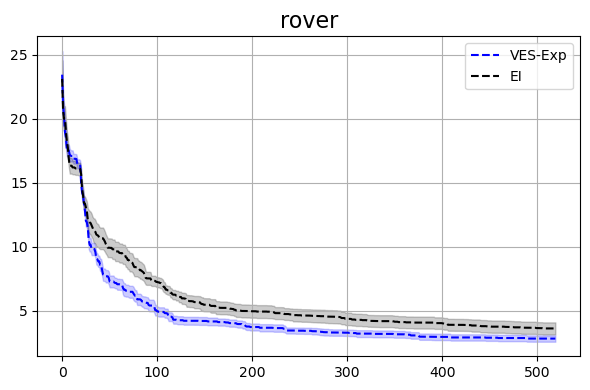

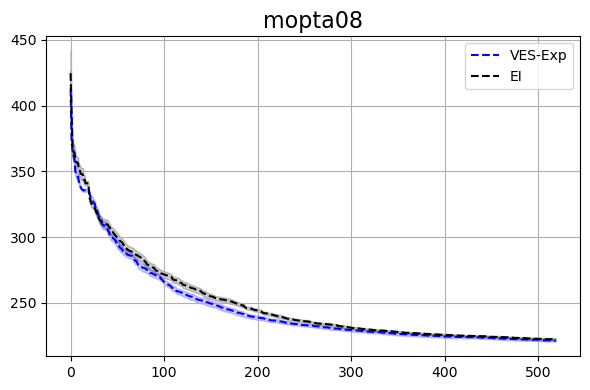

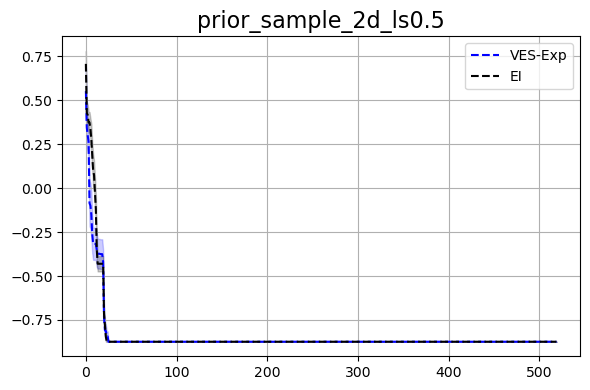

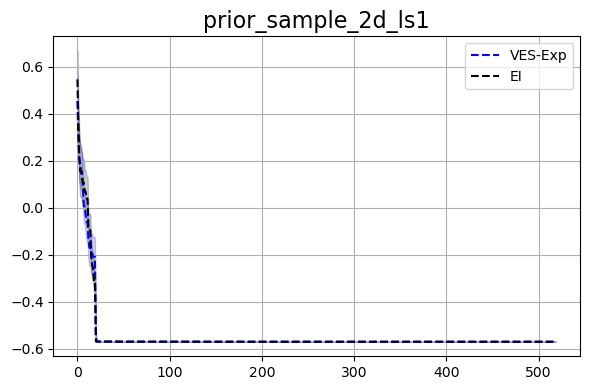

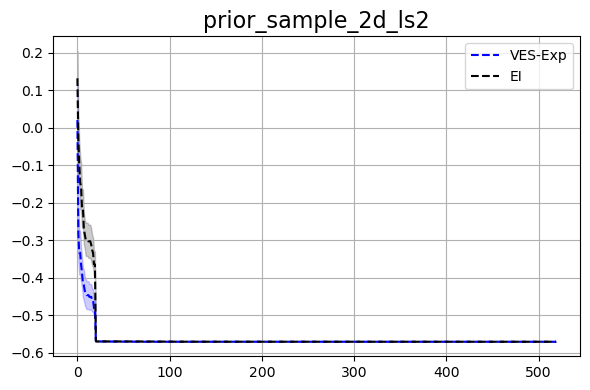

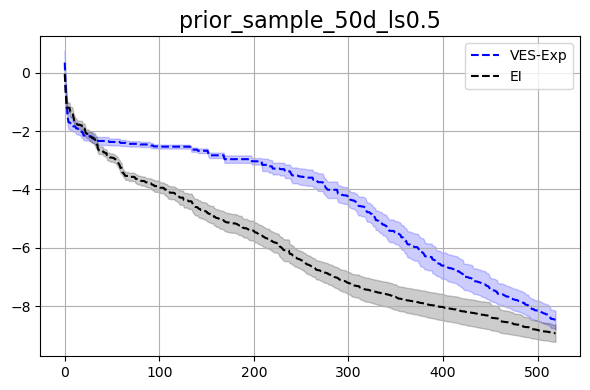

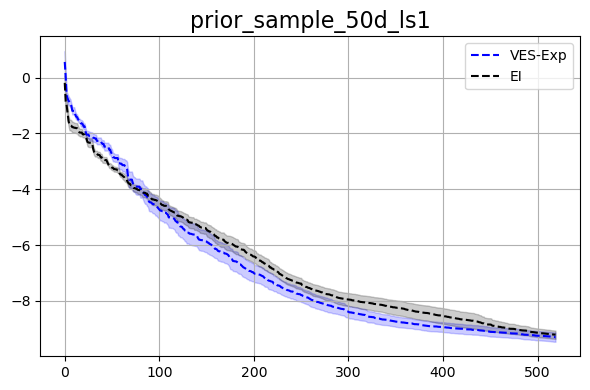

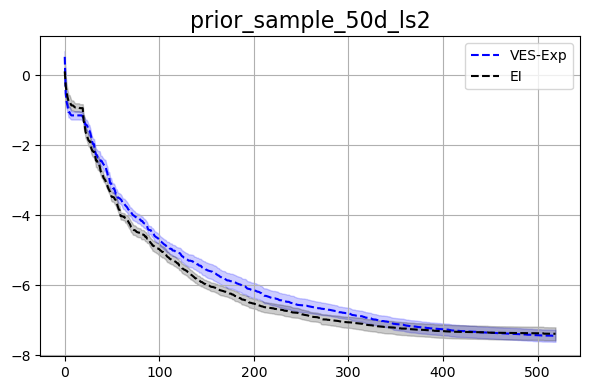

In [52]:
benchmarks = ['branin2','hartmann6', 'rover', 'mopta08', 'prior_sample_2d_ls0.5', 'prior_sample_2d_ls1', 'prior_sample_2d_ls2','prior_sample_50d_ls0.5', 'prior_sample_50d_ls1', 'prior_sample_50d_ls2']

run_dirs = glob.glob('results/ei_vs_ves_exp_sep_17/*')

for benchmark in benchmarks:
    relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]

    def def_dir_match(
            args: dict
    ):
        return args['clamp_min'] == 1e-10 \
            and args['sample_around_best'] == False \
            and args['acqf_raw_samples'] == 512 \
            and args['num_paths'] == 64


    ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
    # remove ei_dirs from relevant_dirs
    relevant_dirs = [d for d in relevant_dirs if d not in ei_dirs]
    
    default_dirs = [d for d in relevant_dirs if def_dir_match(json.load(open(f'{d}/args.json')))]

    fig, ax = plt.subplots(figsize=(6, 4))
    sample_around_bests = [False]
    ablation_dirs = [d for d in relevant_dirs if
                     json.load(open(f'{d}/args.json'))['sample_around_best'] in sample_around_bests] + default_dirs
    ablation_hashes = list(set([int(d.split('/')[-1].split('_')[1]) for d in ablation_dirs]))
    
    for h in ablation_hashes:
        dirs = [d for d in ablation_dirs if int(d.split('/')[-1].split('_')[1]) == h]
        ves_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ves.npy')) for d in dirs]
        if len(ves_y) == 0:
            continue
        min_len = min([len(y) for y in ves_y])
        ves_y = [y[:min_len] for y in ves_y]
        ves_y = -np.stack(ves_y).squeeze(-1)
        ves_y_mean = ves_y.mean(axis=0)
        ves_y_std = ves_y.std(axis=0)/ np.sqrt(len(ves_y))
        ax.plot(ves_y_mean, label=f'VES-Exp', linestyle='--', color='blue')
        ax.fill_between(np.arange(len(ves_y_mean)), ves_y_mean-ves_y_std, ves_y_mean+ves_y_std, alpha=0.2, color='blue')
    ei_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ei.npy')) for d in ei_dirs]
    min_len = min([len(y) for y in ei_y])
    ei_y = [y[:min_len] for y in ei_y]
    ei_y = -np.stack(ei_y).squeeze(-1)
    ei_y_mean = ei_y.mean(axis=0)
    ei_y_std = ei_y.std(axis=0)/ np.sqrt(len(ei_y))
    ax.plot(ei_y_mean, label='EI', color='black', linestyle='--')
    ax.fill_between(np.arange(len(ei_y_mean)), ei_y_mean-ei_y_std, ei_y_mean+ei_y_std, alpha=0.2, color='black')
    ax.legend()
    ax.grid()
    ax.set_title(f'{benchmark}', fontsize=16)
    if benchmark == 'branin2':
        ax.set_yscale('log')
    plt.tight_layout()
    # plt.savefig(f'figs/ei_ves_exp/{benchmark}_ei_vs_ves.pdf', dpi=100)

    # Perform an independent two-sample t-test
    idx = np.linspace(0, ves_y.shape[1]-1).astype(int)
    data1 = ves_y[:, :]
    data2 = ei_y[:, :]
    t_statistic, p_value = stats.ttest_ind(data1, data2)
    # votes = np.isnan(p_value) | (p_value >= 0.5)
    # votes = p_value >= 0.05
    votes = np.array([False] * len(p_value))
    votes[np.isnan(t_statistic)] = True
    votes[~np.isnan(t_statistic) & (p_value >= 0.05)] = True
    majority = np.sum(votes) / len(votes)
    print(f"{benchmark}: {majority}")
    

## VES-Gamma Performance compared with EI and MES

### Prior Samples

#### Learned Lengthscale (MAP)

prior_sample_2d_ls0.5


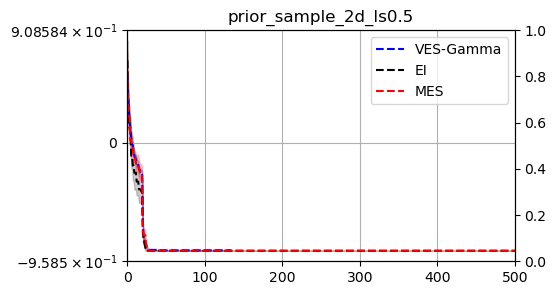

prior_sample_2d_ls1


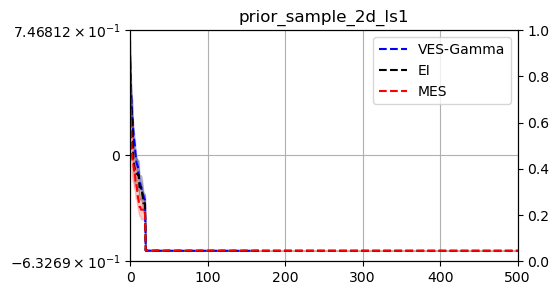

prior_sample_2d_ls2


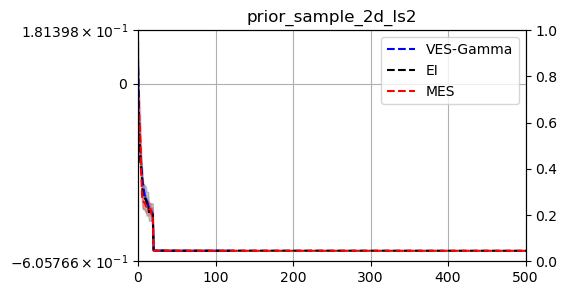

prior_sample_50d_ls0.5


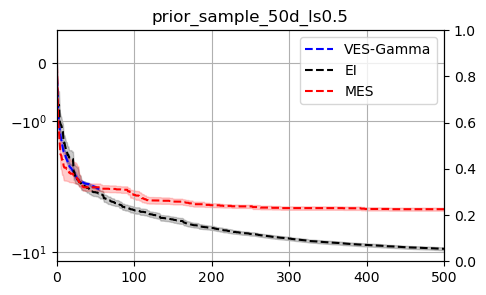

prior_sample_50d_ls1


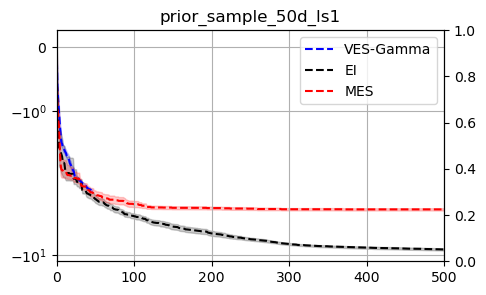

prior_sample_50d_ls2


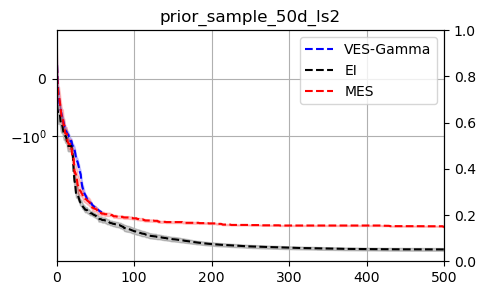

prior_sample_100d_ls0.5


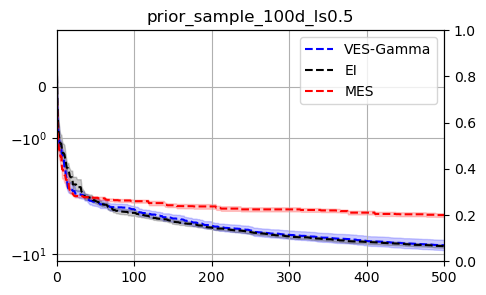

prior_sample_100d_ls1


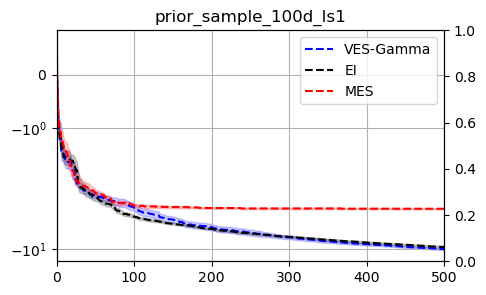

prior_sample_100d_ls2


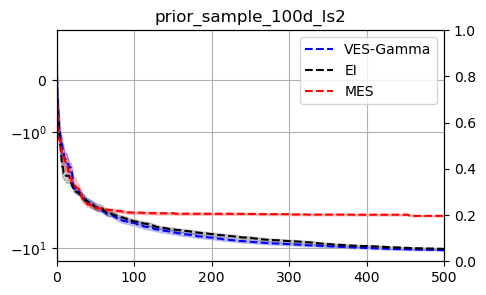

In [47]:
prior_benchmarks = ['prior_sample_2d_ls0.5', 'prior_sample_2d_ls1', 'prior_sample_2d_ls2','prior_sample_50d_ls0.5', 'prior_sample_50d_ls1', 'prior_sample_50d_ls2']
prior_benchmarks_new = ['prior_sample_100d_ls0.5', 'prior_sample_100d_ls1', 'prior_sample_100d_ls2']
benchmarks = [
              'prior_sample_2d_ls0.5', 'prior_sample_2d_ls1', 'prior_sample_2d_ls2',
              'prior_sample_50d_ls0.5', 'prior_sample_50d_ls1', 'prior_sample_50d_ls2', 
              'prior_sample_100d_ls0.5', 'prior_sample_100d_ls1', 'prior_sample_100d_ls2'
              ]

run_dirs_2 = glob.glob('results/ves_gamma_vs_ei2/*')
run_dirs_17 = glob.glob('results/ves_ablation_paths_sep_17/*')
run_dirs_25 = glob.glob('results/ves_100d_gp_prior_sep_25/*')
run_dirs_11 = glob.glob('results/ves_more_highdim_oct_11/*')
run_dirs_add = glob.glob('results/ves_add_benchmarks/*')
run_dirs = run_dirs_2 + run_dirs_17 + run_dirs_25 + run_dirs_11 + run_dirs_add

NUM_PATHS = 256

for benchmark in benchmarks:
    
    def general_dir_match(
            args: dict,
    ):
        if not 'prior_sample' in benchmark:
            return True
        else:
            ls = float(benchmark.split('_')[-1][2:])
            set_ls = args['set_lengthscale'] 
            return set_ls is None# and float(ls) == float(set_ls)
    relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]
    relevant_dirs = [d for d in relevant_dirs if general_dir_match(json.load(open(f'{d}/args.json')))]
    ves_dirs = [d for d in relevant_dirs if f'{d}/train_x_ves.npy' in glob.glob(f'{d}/*')]
    ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
    mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
    
    print(benchmark)
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.grid()
    ax2 = ax.twinx()

    ves_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ves.npy')) for d in ves_dirs]
    if len(ves_y) == 0:
        print('VES missing')
    else:
        min_len = min([len(y) for y in ves_y])
        ves_y = [y[:min_len] for y in ves_y]
        ves_y = -np.stack(ves_y).squeeze(-1)
        ves_y_mean = ves_y.mean(axis=0)
        ves_y_std = ves_y.std(axis=0)/ np.sqrt(len(ves_y))
        ax.plot(ves_y_mean, label='VES-Gamma', color='blue', linestyle='--')
        ax.fill_between(np.arange(len(ves_y_mean)), ves_y_mean-ves_y_std, ves_y_mean+ves_y_std, alpha=0.2, color='blue')
        
    ei_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ei.npy')) for d in ei_dirs]
    if len(ei_y) == 0:
        print('EI missing')
    else:
        min_len = min([len(y) for y in ei_y])
        ei_y = [y[:min_len] for y in ei_y]
        ei_y = -np.stack(ei_y).squeeze(-1)
        ei_y_mean = ei_y.mean(axis=0)
        ei_y_std = ei_y.std(axis=0)/ np.sqrt(len(ei_y))
        ax.plot(ei_y_mean, label='EI', color='black', linestyle='--')
        ax.fill_between(np.arange(len(ei_y_mean)), ei_y_mean-ei_y_std, ei_y_mean+ei_y_std, alpha=0.2, color='black')
    
    mes_y = [np.maximum.accumulate(np.load(f'{d}/train_y_mes.npy')) for d in mes_dirs]
    if len(mes_y) == 0:
        print('MES missing')
    else:
        min_len = min([len(y) for y in mes_y])
        mes_y = [y[:min_len] for y in mes_y]
        mes_y = -np.stack(mes_y).squeeze(-1)
        mes_y_mean = mes_y.mean(axis=0)
        mes_y_std = mes_y.std(axis=0)/ np.sqrt(len(mes_y))
        ax.plot(mes_y_mean, label='MES', color='red', linestyle='--')
        ax.fill_between(np.arange(len(mes_y_mean)), mes_y_mean-mes_y_std, mes_y_mean+mes_y_std, alpha=0.2, color='red')
    
    ax.legend()
    ax.set_title(f'{benchmark}')
    if benchmark == 'branin2':
        ax.set_yscale('log')
    if benchmark.startswith('prior_sample'):
        # find best value
        ax.set_yscale('symlog')
    ax.set_xlim(0, 500)
    # fig.savefig(f'figs/gp_prior/learn/{benchmark}.pdf', format='pdf', bbox_inches='tight', dpi=100)
    plt.show()

#### Correct Lengthscale

NOTE: MES results for prior samples with correct lengthscale are missing


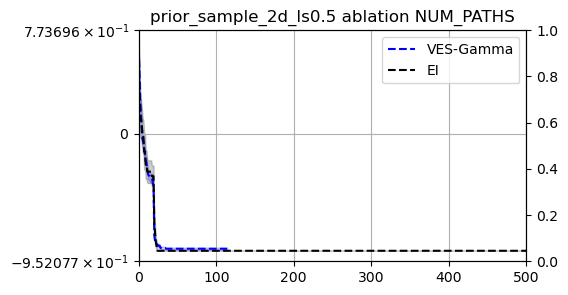

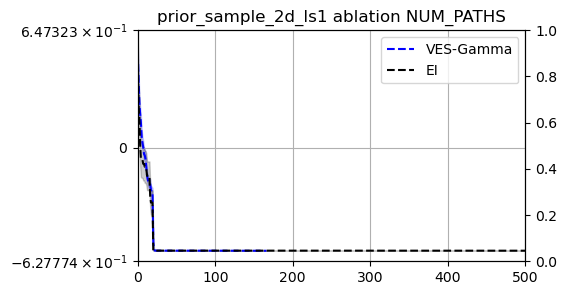

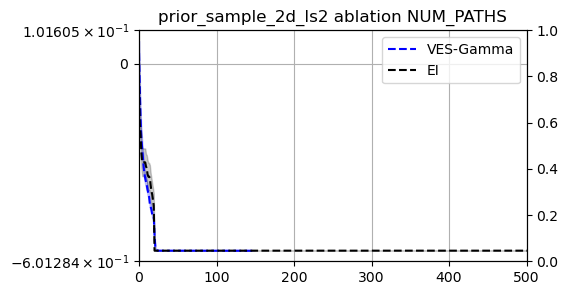

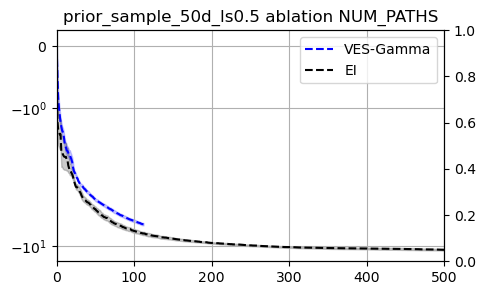

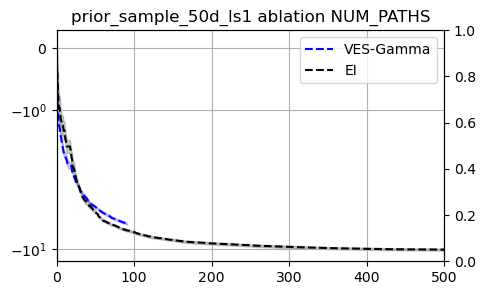

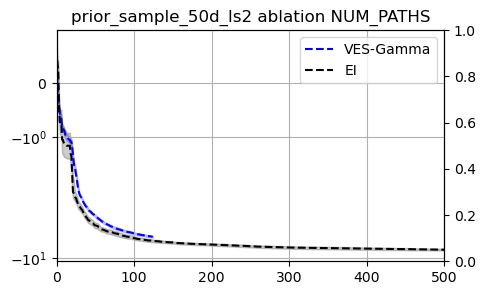

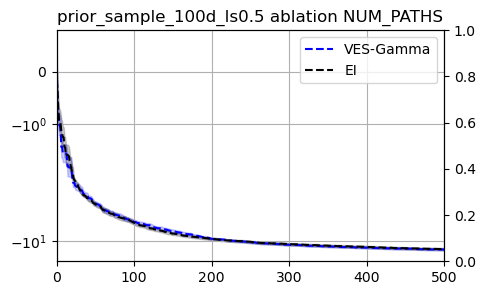

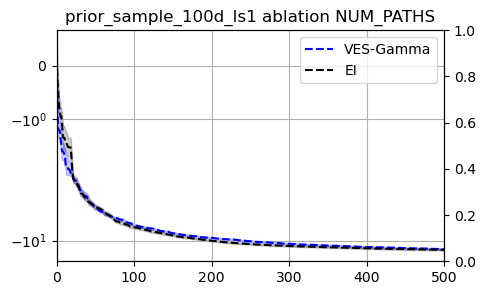

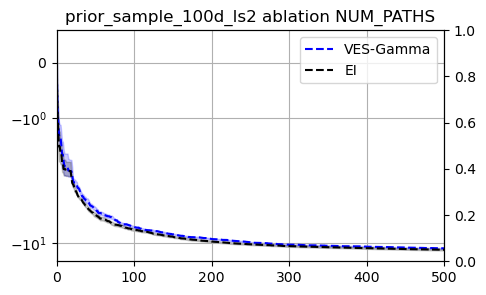

In [48]:
print('='*80)
print('NOTE: MES results for prior samples with correct lengthscale are missing')
print('='*80)
for benchmark in benchmarks:

    def general_dir_match(
            args: dict,
    ):
        if not 'prior_sample' in benchmark:
            return True
        else:
            ls = float(benchmark.split('_')[-1][2:])
            set_ls = args['set_lengthscale']
            return set_ls is not None and set_ls == ls
        
    relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]
    relevant_dirs = [d for d in relevant_dirs if general_dir_match(json.load(open(f'{d}/args.json')))]
    ves_dirs = [d for d in relevant_dirs if f'{d}/train_x_ves.npy' in glob.glob(f'{d}/*')]
    ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
    # mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]

    # ablation NUM_PATHS
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.grid()
    ax2= ax.twinx()
 
    ves_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ves.npy')) for d in ves_dirs]
    min_len = min([len(y) for y in ves_y])
    ves_y = [y[:min_len] for y in ves_y]
    ves_y = -np.stack(ves_y).squeeze(-1)
    ves_y_mean = ves_y.mean(axis=0)
    ves_y_std = ves_y.std(axis=0)/ np.sqrt(len(ves_y))
    
    ei_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ei.npy')) for d in ei_dirs]
    min_len = min([len(y) for y in ei_y])
    ei_y = [y[:min_len] for y in ei_y]
    ei_y = -np.stack(ei_y).squeeze(-1)
    ei_y_mean = ei_y.mean(axis=0)
    ei_y_std = ei_y.std(axis=0)/ np.sqrt(len(ei_y))

    # mes_y = [np.maximum.accumulate(np.load(f'{d}/train_y_mes.npy')) for d in mes_dirs]
    # min_len = min([len(y) for y in mes_y])
    # mes_y = [y[:min_len] for y in mes_y]
    # mes_y = -np.stack(mes_y).squeeze(-1)
    # mes_y_mean = mes_y.mean(axis=0)
    # mes_y_std = mes_y.std(axis=0)/ np.sqrt(len(mes_y))

    ax.plot(ves_y_mean, label='VES-Gamma', color='blue', linestyle='--')
    ax.fill_between(np.arange(len(ves_y_mean)), ves_y_mean-ves_y_std, ves_y_mean+ves_y_std, alpha=0.2, color='blue')

    ax.plot(ei_y_mean, label='EI', color='black', linestyle='--')
    ax.fill_between(np.arange(len(ei_y_mean)), ei_y_mean-ei_y_std, ei_y_mean+ei_y_std, alpha=0.2, color='black')
    
    # ax.plot(mes_y_mean, label='MES', color='red', linestyle='--')
    # ax.fill_between(np.arange(len(mes_y_mean)), mes_y_mean-mes_y_std, mes_y_mean+mes_y_std, alpha=0.2, color='red')
    
    ax.legend()
    ax.set_title(f'{benchmark} ablation NUM_PATHS')
    if benchmark == 'branin2':
        ax.set_yscale('log')
    if benchmark.startswith('prior_sample'):
        ax.set_yscale('symlog')
    ax.set_xlim(0, 500)

    plt.show()

### Test Functions

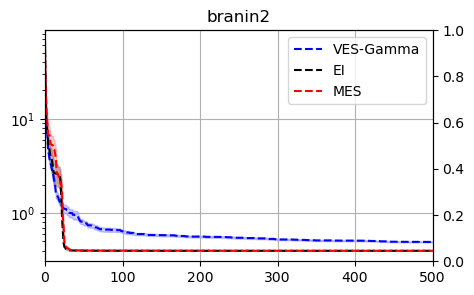

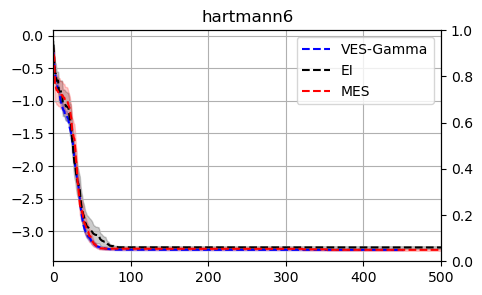

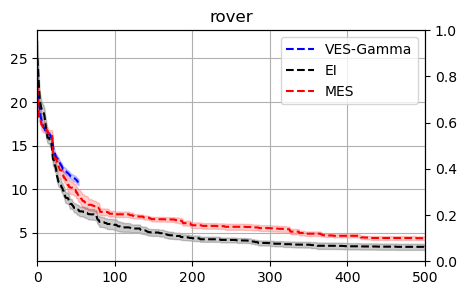

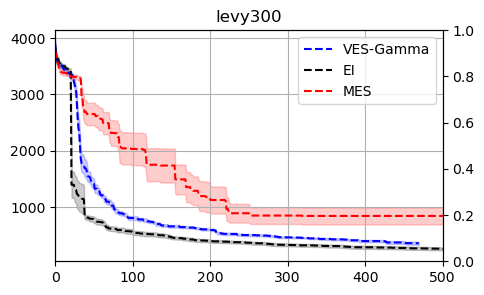

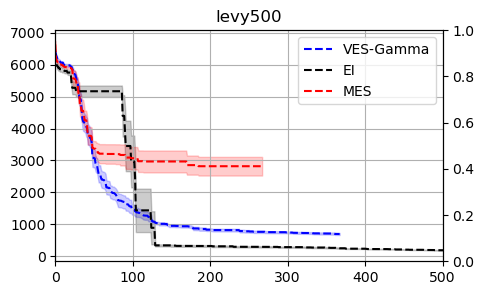

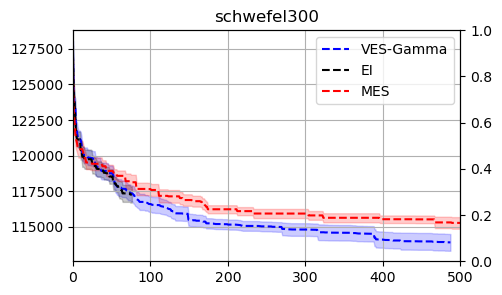

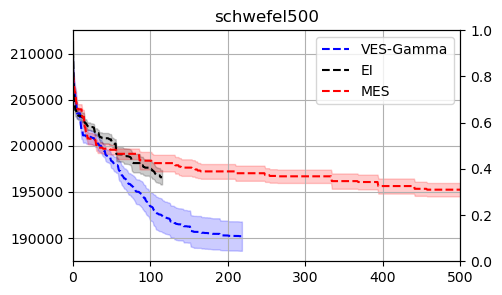

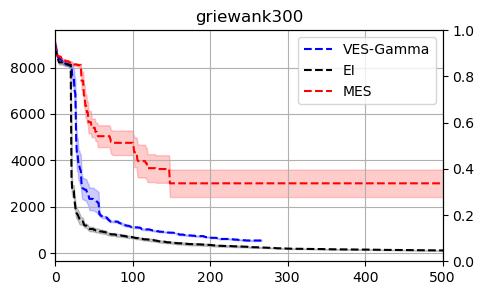

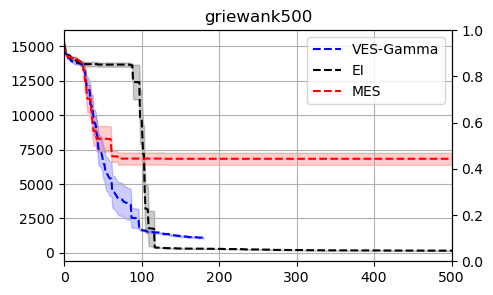

In [49]:
test_benchmarks = ['branin2','hartmann6', 'rover', 'levy300', 'levy500', 'schwefel300', 'schwefel500', 'griewank300', 'griewank500']

for benchmark in test_benchmarks:

    relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]
    ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
    mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
    ves_dirs = [d for d in relevant_dirs if f'{d}/train_x_ves.npy' in glob.glob(f'{d}/*')]
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.grid()
    ax2 = ax.twinx()

    ves_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ves.npy')) for d in ves_dirs]
    if len(ves_y) == 0:
        print('VES missing')
    else:
        min_len = min([len(y) for y in ves_y])
        ves_y = [y[:min_len] for y in ves_y]
        ves_y = -np.stack(ves_y).squeeze(-1)
        ves_y_mean = ves_y.mean(axis=0)
        ves_y_std = ves_y.std(axis=0)/ np.sqrt(len(ves_y))
        ax.plot(ves_y_mean, label='VES-Gamma', color='blue', linestyle='--')
        ax.fill_between(np.arange(len(ves_y_mean)), ves_y_mean-ves_y_std, ves_y_mean+ves_y_std, alpha=0.2, color='blue')
        
    ei_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ei.npy')) for d in ei_dirs]
    if len(ei_y) == 0:
        print('EI missing')
    else:
        min_len = min([len(y) for y in ei_y])
        ei_y = [y[:min_len] for y in ei_y]
        ei_y = -np.stack(ei_y).squeeze(-1)
        ei_y_mean = ei_y.mean(axis=0)
        ei_y_std = ei_y.std(axis=0)/ np.sqrt(len(ei_y))
        ax.plot(ei_y_mean, label='EI', color='black', linestyle='--')
        ax.fill_between(np.arange(len(ei_y_mean)), ei_y_mean-ei_y_std, ei_y_mean+ei_y_std, alpha=0.2, color='black')
    
    mes_y = [np.maximum.accumulate(np.load(f'{d}/train_y_mes.npy')) for d in mes_dirs]
    if len(mes_y) == 0:
        print('MES missing')
    else:
        min_len = min([len(y) for y in mes_y])
        mes_y = [y[:min_len] for y in mes_y]
        mes_y = -np.stack(mes_y).squeeze(-1)
        mes_y_mean = mes_y.mean(axis=0)
        mes_y_std = mes_y.std(axis=0)/ np.sqrt(len(mes_y))
        ax.plot(mes_y_mean, label='MES', color='red', linestyle='--')
        ax.fill_between(np.arange(len(mes_y_mean)), mes_y_mean-mes_y_std, mes_y_mean+mes_y_std, alpha=0.2, color='red')
    
    ax.legend()
    ax.set_title(f'{benchmark}')
    if benchmark == 'branin2':
        ax.set_yscale('log')
    if benchmark.startswith('prior_sample'):
        # find best value
        ax.set_yscale('symlog')
    ax.set_xlim(0, 500)
    # fig.savefig(f'figs/gp_prior/learn/{benchmark}.pdf', format='pdf', bbox_inches='tight', dpi=100)
    plt.show()

### Real-world Benchmarks 

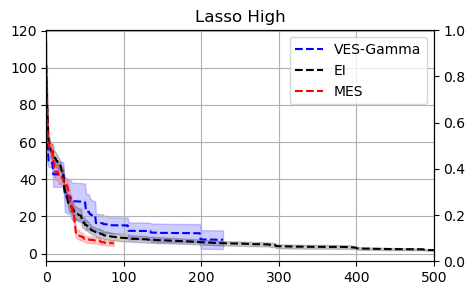

VES missing


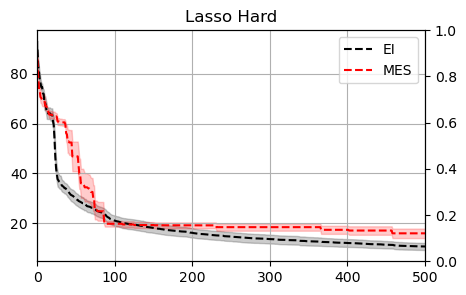

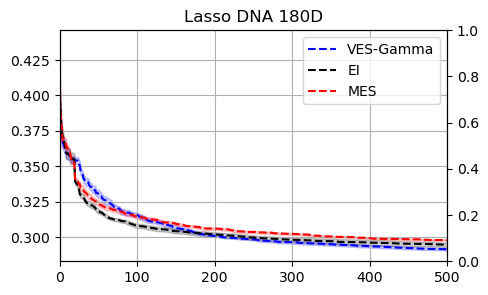

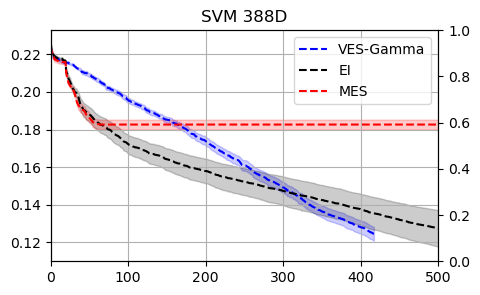

In [50]:
real_benchmarks = ['lasso-high', 'lasso-hard', 'lasso-dna', 'svm']
names = {
    'lasso-high': 'Lasso High',
    'lasso-hard': 'Lasso Hard',
    'lasso-dna': 'Lasso DNA 180D',
    'svm': 'SVM 388D'
}

for benchmark in real_benchmarks:
    relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]
    ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
    mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
    ves_dirs = [d for d in relevant_dirs if f'{d}/train_x_ves.npy' in glob.glob(f'{d}/*')]

    fig, ax = plt.subplots(figsize=(5, 3))
    ax.grid()
    ax2 = ax.twinx()

    ves_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ves.npy')) for d in ves_dirs]
    if len(ves_y) == 0:
        print('VES missing')
    else:
        min_len = min([len(y) for y in ves_y])
        ves_y = [y[:min_len] for y in ves_y]
        ves_y = -np.stack(ves_y).squeeze(-1)
        ves_y_mean = ves_y.mean(axis=0)
        ves_y_std = ves_y.std(axis=0)/ np.sqrt(len(ves_y))
        ax.plot(ves_y_mean, label='VES-Gamma', color='blue', linestyle='--')
        ax.fill_between(np.arange(len(ves_y_mean)), ves_y_mean-ves_y_std, ves_y_mean+ves_y_std, alpha=0.2, color='blue')
        
    ei_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ei.npy')) for d in ei_dirs]
    if len(ei_y) == 0:
        print('EI missing')
    else:
        min_len = min([len(y) for y in ei_y])
        ei_y = [y[:min_len] for y in ei_y]
        ei_y = -np.stack(ei_y).squeeze(-1)
        ei_y_mean = ei_y.mean(axis=0)
        ei_y_std = ei_y.std(axis=0)/ np.sqrt(len(ei_y))
        ax.plot(ei_y_mean, label='EI', color='black', linestyle='--')
        ax.fill_between(np.arange(len(ei_y_mean)), ei_y_mean-ei_y_std, ei_y_mean+ei_y_std, alpha=0.2, color='black')
    
    mes_y = [np.maximum.accumulate(np.load(f'{d}/train_y_mes.npy')) for d in mes_dirs]
    if len(mes_y) == 0:
        print('MES missing')
    else:
        min_len = min([len(y) for y in mes_y])
        mes_y = [y[:min_len] for y in mes_y]
        mes_y = -np.stack(mes_y).squeeze(-1)
        mes_y_mean = mes_y.mean(axis=0)
        mes_y_std = mes_y.std(axis=0)/ np.sqrt(len(mes_y))
        ax.plot(mes_y_mean, label='MES', color='red', linestyle='--')
        ax.fill_between(np.arange(len(mes_y_mean)), mes_y_mean-mes_y_std, mes_y_mean+mes_y_std, alpha=0.2, color='red')
    
    ax.legend()
    ax.set_title(names[f'{benchmark}'])
    if benchmark == 'branin2':
        ax.set_yscale('log')
    if benchmark.startswith('prior_sample'):
        # find best value
        ax.set_yscale('symlog')
    ax.set_xlim(0, 500)
    # fig.savefig(f'figs/gp_prior/learn/{benchmark}.pdf', format='pdf', bbox_inches='tight', dpi=100)
    plt.show()

### High-dimensional Prior Tests

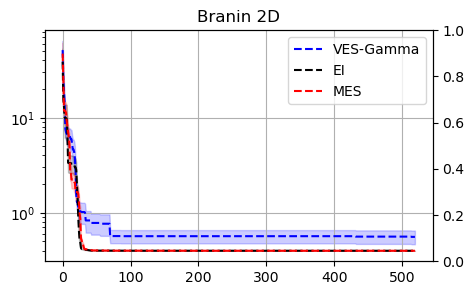

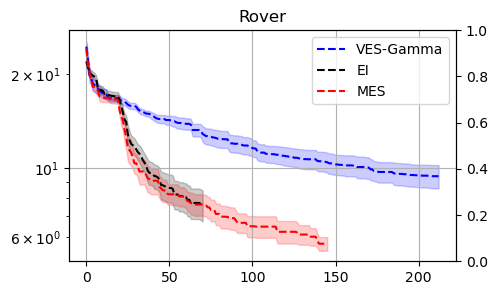

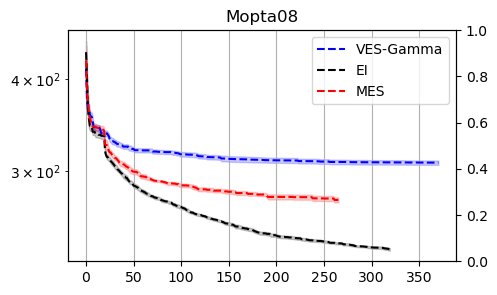

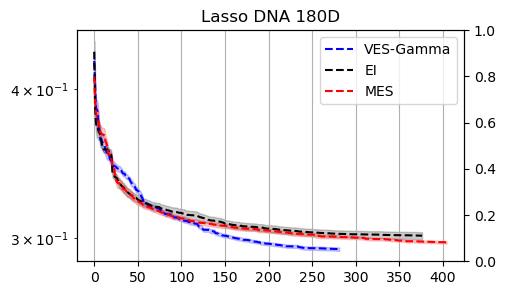

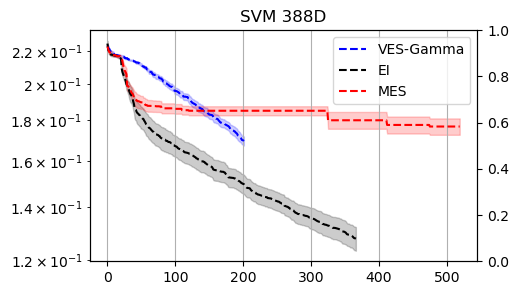

In [51]:
benchmarks = ['branin2','rover', 'mopta08', 'lasso-dna', 'svm']
names = {
    'branin2': 'Branin 2D',
    'rover': 'Rover',
    'mopta08': 'Mopta08',
    'lasso-dna': 'Lasso DNA 180D',
    'svm': 'SVM 388D'
}

run_dirs = glob.glob('results/ves_vbo_prior/*')

for benchmark in benchmarks:
    
    relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]

    ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
    mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
    ves_dirs = [d for d in relevant_dirs if f'{d}/train_x_ves.npy' in glob.glob(f'{d}/*')]


    fig, ax = plt.subplots(figsize=(5, 3))
    ax.grid()
    ax2 = ax.twinx()

    ves_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ves.npy')) for d in ves_dirs]
    min_len = min([len(y) for y in ves_y])
    ves_y = [y[:min_len] for y in ves_y]
    ves_y = -np.stack(ves_y).squeeze(-1)
    ves_y_mean = ves_y.mean(axis=0)
    ves_y_std = ves_y.std(axis=0)/ np.sqrt(len(ves_y))
        
    ei_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ei.npy')) for d in ei_dirs]
    min_len = min([len(y) for y in ei_y])
    ei_y = [y[:min_len] for y in ei_y]
    ei_y = -np.stack(ei_y).squeeze(-1)
    ei_y_mean = ei_y.mean(axis=0)
    ei_y_std = ei_y.std(axis=0)/ np.sqrt(len(ei_y))
    
    mes_y = [np.maximum.accumulate(np.load(f'{d}/train_y_mes.npy')) for d in mes_dirs]
    min_len = min([len(y) for y in mes_y])
    mes_y = [y[:min_len] for y in mes_y]
    mes_y = -np.stack(mes_y).squeeze(-1)
    mes_y_mean = mes_y.mean(axis=0)
    mes_y_std = mes_y.std(axis=0)/ np.sqrt(len(mes_y))

    ax.plot(ves_y_mean, label='VES-Gamma', color='blue', linestyle='--')
    ax.fill_between(np.arange(len(ves_y_mean)), ves_y_mean-ves_y_std, ves_y_mean+ves_y_std, alpha=0.2, color='blue')
    
    ax.plot(ei_y_mean, label='EI', color='black', linestyle='--')
    ax.fill_between(np.arange(len(ei_y_mean)), ei_y_mean-ei_y_std, ei_y_mean+ei_y_std, alpha=0.2, color='black')
    
    ax.plot(mes_y_mean, label='MES', color='red', linestyle='--')
    ax.fill_between(np.arange(len(mes_y_mean)), mes_y_mean-mes_y_std, mes_y_mean+mes_y_std, alpha=0.2, color='red')
    
    ax.legend()
    ax.set_yscale('log')
    ax.set_title(names[f'{benchmark}'])

    plt.show()
    
    